In [1]:

# train_yolo_stanford40.py
# Full pipeline: convert Stanford40 XML annotations to YOLOv8 format,
# install dependencies, train YOLOv8-L with SGD+momentum, evaluate, and demo inference.

# 0. Install dependencies (run in a Jupyter/Notebook environment)
!pip install ultralytics
!pip install opencv-python-headless

import os
import shutil
import xml.etree.ElementTree as ET
import torch
from ultralytics import YOLO
import cv2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
# 1. Device setup
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

# 2. Paths (adjust for Kaggle or local)
ROOT      = os.getenv('STANFORD40_PATH', '/kaggle/input/dumatenginua')
WORKING   = os.getenv('WORKING_DIR', '/kaggle/working')
YOLO_DATA = os.path.join(WORKING, 'yolov8_data')
IMG_DIR   = os.path.join(ROOT, 'JPEGImages')
XML_DIR   = os.path.join(ROOT, 'XMLAnnotations')
SPLIT_DIR = os.path.join(ROOT, 'ImageSplits')
PROJECT   = os.path.join(WORKING, 'runs')
RUN_NAME  = 'yolov8l_stanford40'

# 3. Prepare YOLOv8 dataset structure
for sub in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    os.makedirs(os.path.join(YOLO_DATA, sub), exist_ok=True)

Using device: cuda


In [3]:
# 4. Read train/val splits
def read_split(file_path):
    with open(file_path) as f:
        return [line.strip().split(".")[0] for line in f if line.strip().split(".")[0]]

train_ids = read_split(os.path.join(SPLIT_DIR, 'train.txt'))
val_ids   = read_split(os.path.join(SPLIT_DIR, 'test.txt'))

# 5. Convert XML annotations to YOLO .txt format
def convert_to_yolo(ids_list, split):
    for img_id in ids_list:
        xml_path = os.path.join(XML_DIR, f"{img_id}.xml")
        img_path = os.path.join(IMG_DIR, f"{img_id}.jpg")
        if not os.path.exists(xml_path) or not os.path.exists(img_path):
            continue

        # Copy image
        dst_img = os.path.join(YOLO_DATA, 'images', split, f"{img_id}.jpg")
        shutil.copy(img_path, dst_img)

        # Parse annotation
        tree = ET.parse(xml_path)
        root = tree.getroot()
        img_w = float(root.findtext('size/width'))
        img_h = float(root.findtext('size/height'))

        yolo_lines = []
        for obj in root.findall('object'):
            if obj.findtext('name').lower() != 'person':
                continue
            bb = obj.find('bndbox')
            xmin = float(bb.findtext('xmin'))
            ymin = float(bb.findtext('ymin'))
            xmax = float(bb.findtext('xmax'))
            ymax = float(bb.findtext('ymax'))
            # Normalize coords
            x_c = (xmin + xmax) / 2 / img_w
            y_c = (ymin + ymax) / 2 / img_h
            w   = (xmax - xmin) / img_w
            h   = (ymax - ymin) / img_h
            yolo_lines.append(f"0 {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

        if yolo_lines:
            lbl_dst = os.path.join(YOLO_DATA, 'labels', split, f"{img_id}.txt")
            with open(lbl_dst, 'w') as f:
                f.write("\n".join(yolo_lines))

# Run conversion
convert_to_yolo(train_ids, 'train')
convert_to_yolo(val_ids,   'val')
print('✅ Converted XML annotations to YOLO format')


✅ Converted XML annotations to YOLO format


In [4]:
# 6. Create data.yaml for YOLOv8
data_yaml = os.path.join(YOLO_DATA, 'data.yaml')
with open(data_yaml, 'w') as f:
    f.write(f"""
path: {YOLO_DATA}
train: images/train
val:   images/val
nc: 1
names: ['person']
""".strip())
print(f"✅ Created data.yaml at {data_yaml}")

# 7. Initialize YOLOv8-L (auto-download weights)
model = YOLO('yolov8l.pt')  # auto-download if missing

# 8. Train YOLOv8-L with SGD + momentum
metrics = model.train(
    data        = data_yaml,
    epochs      = 10,
    imgsz       = 640,
    batch       = 16,
    lr0         = 1e-3,
    optimizer   = 'SGD',
    momentum    = 0.9,
    device      = DEVICE,
    workers     = 4,
    project     = PROJECT,
    name        = RUN_NAME,
    save_period = 5,
    plots       = True,
    verbose     = True
)
print(f"✅ Training complete. Outputs at {os.path.join(PROJECT, RUN_NAME)}")

# 9. Final evaluation on validation set
print("\n🔍 Final validation metrics:")
val_results = model.val(data=data_yaml, device=DEVICE)
print(val_results)

# 10. Demo inference on a few samples
demo_ids = train_ids[:5]
for img_id in demo_ids:
    img_path = os.path.join(IMG_DIR, f"{img_id}.jpg")
    results = model.predict(source=img_path, imgsz=640, conf=0.25, device=DEVICE)
    res = results[0]
    img = cv2.imread(img_path)
    for box in res.boxes.xyxy.cpu().numpy().astype(int):
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    out_path = os.path.join(WORKING, f"demo_{img_id}.jpg")
    cv2.imwrite(out_path, img)
    print(f"➡️ Saved demo output: {out_path}")

print("🎉 Script run complete!")

✅ Created data.yaml at /kaggle/working/yolov8_data/data.yaml


100%|██████████| 83.7M/83.7M [00:00<00:00, 220MB/s]


Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolov8_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=yolov8l_stanford40, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 925.8±517.1 MB/s, size: 31.6 KB)


train: Scanning /kaggle/working/yolov8_data/labels/train... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:02<00:00, 1422.64it/s]


train: New cache created: /kaggle/working/yolov8_data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 327.4±157.0 MB/s, size: 45.0 KB)


val: Scanning /kaggle/working/yolov8_data/labels/val... 5532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5532/5532 [00:04<00:00, 1248.26it/s]


val: New cache created: /kaggle/working/yolov8_data/labels/val.cache
Plotting labels to /kaggle/working/runs/yolov8l_stanford40/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/yolov8l_stanford40
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.68G     0.4003      1.001      1.027         16        640: 100%|██████████| 250/250 [03:53<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:30<00:00,  1.92it/s]


                   all       5532       5532      0.861      0.946      0.953      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.99G     0.3781     0.4259     0.9974         16        640: 100%|██████████| 250/250 [03:49<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:28<00:00,  1.96it/s]

                   all       5532       5532      0.902      0.955      0.965      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      9.98G     0.3675     0.3616     0.9875         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.97it/s]

                   all       5532       5532      0.909      0.965      0.976      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      9.97G     0.3678     0.3259     0.9815         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.97it/s]

                   all       5532       5532      0.931      0.957      0.982      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10       9.5G     0.3556     0.2995     0.9696         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.98it/s]

                   all       5532       5532      0.937       0.96      0.983      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.49G     0.3346     0.2703      0.954         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.98it/s]

                   all       5532       5532      0.942      0.959      0.983      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.49G     0.3216     0.2466     0.9434         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.98it/s]

                   all       5532       5532      0.932      0.966      0.983      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.97G     0.3175      0.236     0.9399         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.98it/s]

                   all       5532       5532      0.944      0.958      0.985      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      9.49G        0.3     0.2235     0.9274         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:27<00:00,  1.98it/s]

                   all       5532       5532      0.945      0.961      0.985      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       9.5G     0.2935     0.2118      0.921         16        640: 100%|██████████| 250/250 [03:48<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:26<00:00,  1.99it/s]

                   all       5532       5532      0.944      0.965      0.985       0.93



10 epochs completed in 0.885 hours.
Optimizer stripped from /kaggle/working/runs/yolov8l_stanford40/weights/last.pt, 87.6MB
Optimizer stripped from /kaggle/working/runs/yolov8l_stanford40/weights/best.pt, 87.6MB

Validating /kaggle/working/runs/yolov8l_stanford40/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 173/173 [01:29<00:00,  1.92it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5532       5532      0.944      0.965      0.985      0.931
Speed: 0.1ms preprocess, 12.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/yolov8l_stanford40
✅ Training complete. Outputs at /kaggle/working/runs/yolov8l_stanford40

🔍 Final validation metrics:
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 797.4±306.1 MB/s, size: 29.2 KB)


val: Scanning /kaggle/working/yolov8_data/labels/val.cache... 5532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5532/5532 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 346/346 [01:34<00:00,  3.68it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       5532       5532      0.944      0.965      0.985      0.931
Speed: 0.2ms preprocess, 13.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/runs/yolov8l_stanford402
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0daa963190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031


image 1/1 /kaggle/input/dumatenginua/JPEGImages/applauding_001.jpg: 640x480 1 person, 22.1ms
Speed: 1.8ms preprocess, 22.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


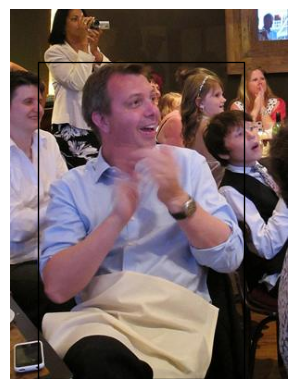

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ultralytics import YOLO
from PIL import Image
import torch

# 1. Load model (best checkpoint or last)
model_path = '/kaggle/working/runs/yolov8l_stanford40/weights/best.pt'  # adjust if needed
model = YOLO(model_path)

# 2. Choose an image to demo
image_path = '/kaggle/input/dumatenginua/JPEGImages/applauding_001.jpg'  # replace with your image

# 3. Inference
results = model.predict(source=image_path, imgsz=640, conf=0.25, device=('cuda' if torch.cuda.is_available() else 'cpu'))
res = results[0]

# 4. Plot with matplotlib
img = Image.open(image_path)
fig, ax = plt.subplots()
ax.imshow(img)
ax.axis('off')

# Add bounding boxes
for box in res.boxes.xyxy.cpu().numpy():
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False)
    ax.add_patch(rect)

plt.show()